In [1]:
# Uncomment pyximport to compile instead of running pure python
#import pyximport; pyximport.install(language_level=3)

from matplotlib import pyplot as plt
from py_ballisticcalc import Velocity, Distance, Angular
from py_ballisticcalc import DragModel, TableG7
from py_ballisticcalc import Ammo
from py_ballisticcalc import Weapon, Shot, Calculator
from py_ballisticcalc import Settings as Set

In [2]:
# Define standard .308
dm = DragModel(0.22, TableG7, 168, 0.308)
ammo = Ammo(dm, 1.22, Velocity(2600, Velocity.FPS))
weapon = Weapon(4, 12)

# Establish 100-yard zero
calc = Calculator(weapon, ammo)
zero_elevation = calc.set_weapon_zero(Distance.Yard(100))
print(f'Barrel elevation for zero: {zero_elevation << Angular.MOA}')

Barrel elevation for zero: 6.41moa


ext True
Danger space at 300.0yd for 50.0cm tall target ranges from 187.533yd to 361.7yd


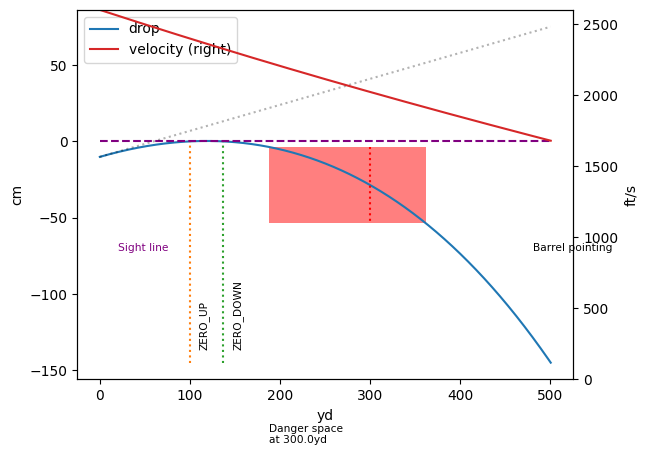

In [3]:
# Plot trajectory out to 500 yards
shot = Shot(weapon = weapon)
shot_result = calc.fire(shot, range=500, extra_data=True)
ax = shot_result.plot()
# Find danger space for a half-meter tall target at 300 yards
danger_space = shot_result.danger_space(Distance.Yard(300), Distance.Meter(.5), Angular.Mil(0))
print(danger_space)
# Highlight danger space on the plot
danger_space.overlay(ax)
plt.show()

In [5]:
# Now find the elevation needed to hit a target at 200 yards with 10-degree look angle
# Establish 100-yard zero
look = Angular.Degree(10)
target = Distance.Yard(200)
zero_elevation = calc.set_weapon_zero(target, look)
print(f'To hit target at {target << Set.Units.distance} sighted at a ' 
      f'{look << Angular.Degree} look angle, zero elevation={zero_elevation << Angular.MOA}')

To hit target at 200.0yd sighted at a 10.0° look angle, zero elevation=7.34moa


ext True
Danger space at 300.0yd for 50.0cm tall target ranges from 164.667yd to 362.433yd


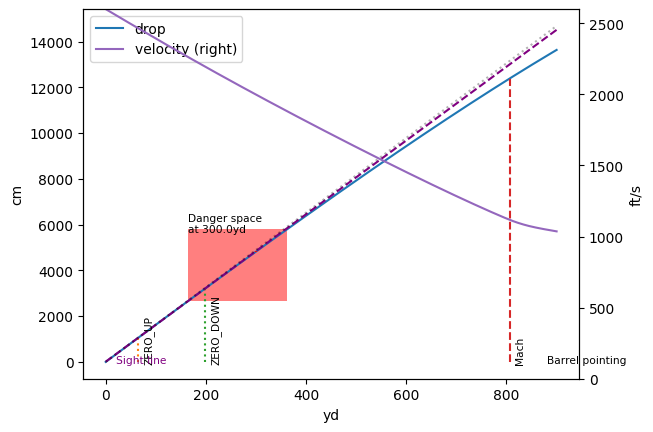

In [6]:
shot_result = calc.fire(Shot(weapon=weapon, look_angle=look), range=900, extra_data=True)
ax = shot_result.plot()
# Find danger space for a target
danger_space = shot_result.danger_space(Distance.Yard(300), Distance.Meter(.5), look)
print(danger_space)
# Highlight danger space on the plot
danger_space.overlay(ax)
plt.show()

In [6]:
shot_result.dataframe.to_clipboard()